,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None
fare_amount vs pickup_longitude :  0.010457264906930778
fare_amount vs pickup_latitude :  -0.008481012987697805
fare_amount vs dropoff_longitude :  0.008985187290858758
fare_amount vs dropoff_latitude :  -0.011012835160032864
fare_amount vs passenger_count :  0.010149925554529177

p

C:\Users\Abhishek Kakakde\AppData\Local\Temp\ipykernel_4636\4039746246.py:85: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(self.dataset.corr(), annot=True, vmin=-1, vmax=1, center=0)


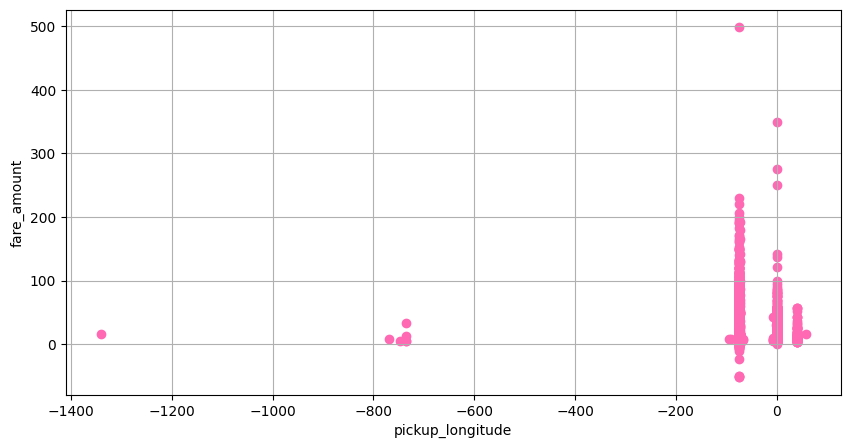

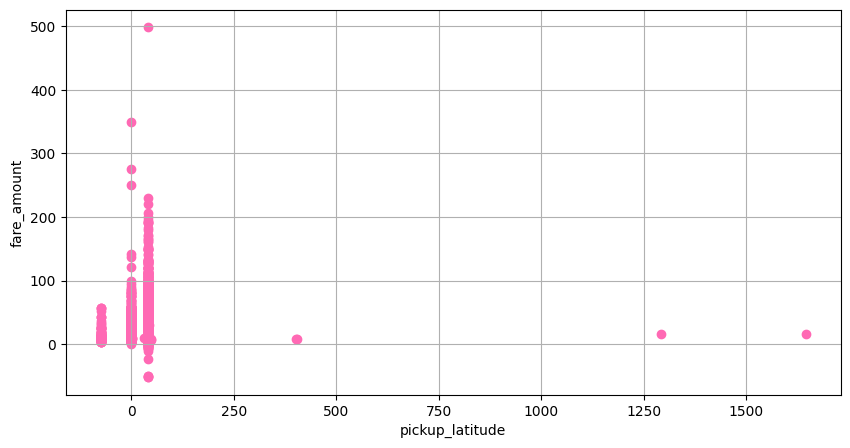

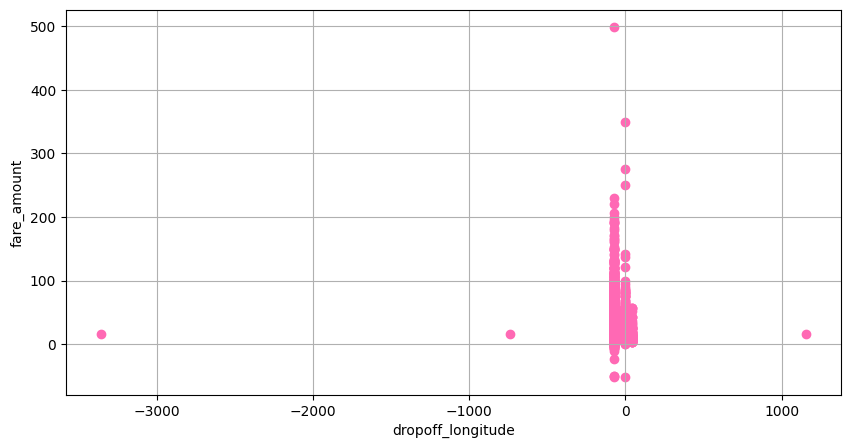

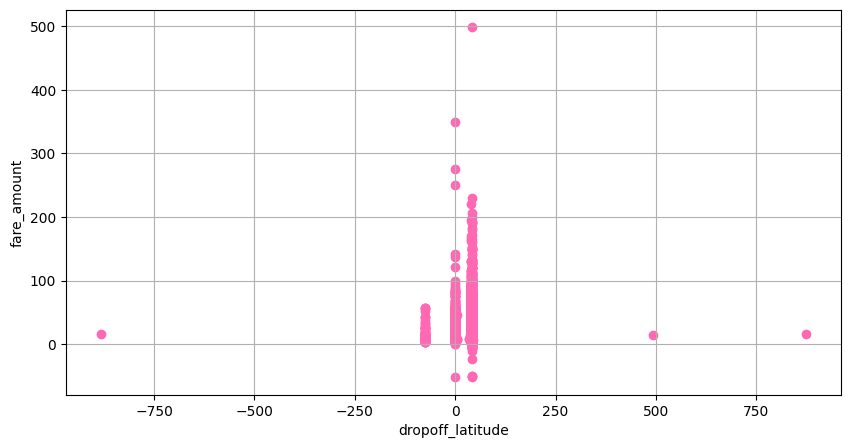

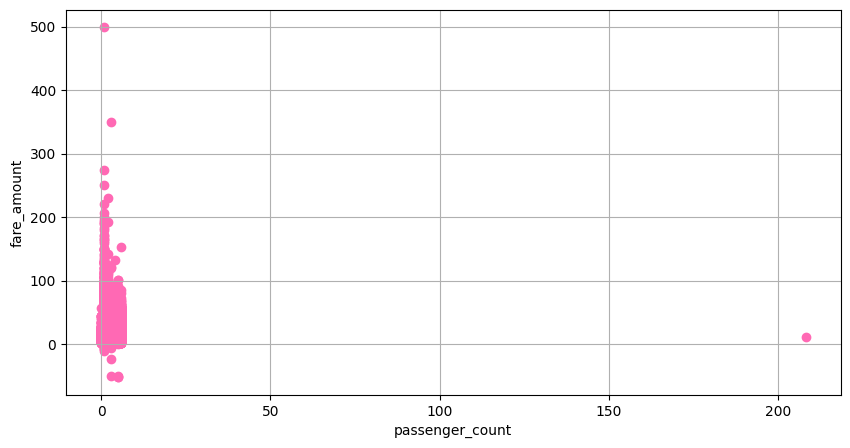

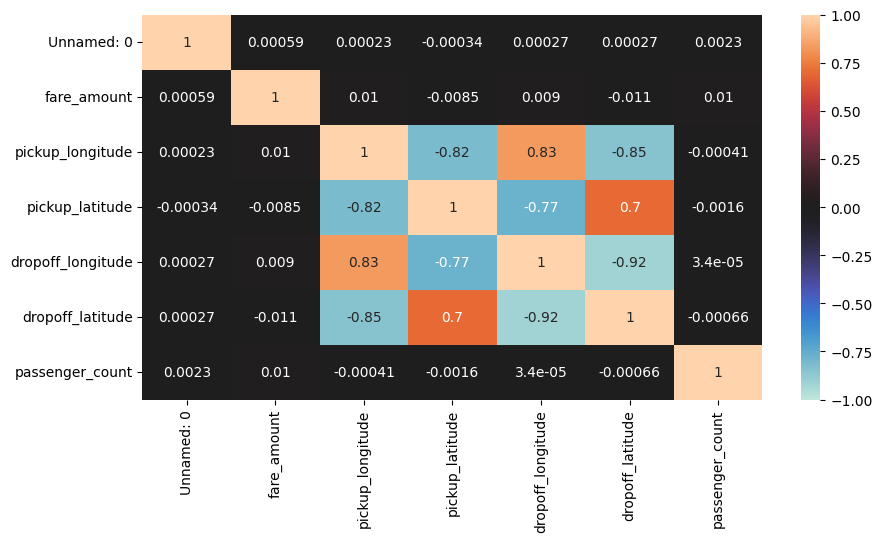

0.015640880544940172


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from IPython.display import display
from scipy.stats import pearsonr
import geopy.distance as gd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns

class Uber:
    dataset_name = "uber.csv"

    def load_dataset(self):
        self.dataset = pd.read_csv(self.dataset_name)
    
    def show_dataset(self):
        display(self.dataset.head())
    
    def show_info(self):
        print(self.dataset.info())
    
    def drop_column(self, column):
        self.dataset.drop(column, axis = 1, inplace=True)
    
    def interpolate_nan_values(self):
        self.dataset["dropoff_longitude"] = self.dataset["dropoff_longitude"].interpolate(method="linear", limit_direction="forward")
        self.dataset["dropoff_latitude"] = self.dataset["dropoff_latitude"].interpolate(method="linear", limit_direction="forward")
        return self.dataset
    
    def add_column(self):
        self.dataset = self.dataset[(self.dataset.pickup_latitude < 90) & (self.dataset.dropoff_latitude < 90) &
                        (self.dataset.pickup_latitude > -90) & (self.dataset.dropoff_latitude > -90) &
                        (self.dataset.pickup_longitude < 180) & (self.dataset.dropoff_longitude < 180) &
                        (self.dataset.pickup_longitude > -180) & (self.dataset.dropoff_longitude > -180)]
        
        self.dataset["Distance"] = [ gd.distance((self.dataset.pickup_latitude[i], self.dataset.pickup_longitude[i]), 
                                                 (self.dataset.dropoff_latitude[i], self.dataset.dropoff_longitude[i])).m for i in self.dataset.index ]
        
        return self.dataset
    
    def add_features(self):
        self.dataset["Weekday"] = [ day.weekday() for day in self.dataset.pickup_datetime]
        self.dataset["Year"] = [day.year for day in self.dataset.pickup_datetime]
        self.dataset["Month"] = [day.month for day in self.dataset.pickup_datetime]

        return self.dataset

    def preprocess(self):

        self.drop_column("Unnamed: 0")

        self.dataset["key"] = pd.to_datetime(self.dataset["key"], format="%Y-%m-%d %H:%M:%S.%f")
        self.dataset["pickup_datetime"] = pd.to_datetime(self.dataset["pickup_datetime"], format="%Y-%m-%d %H:%M:%S %Z")

        self.dataset = self.interpolate_nan_values()
        self.dataset = self.add_column()
        
        self.drop_column(["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])

        self.dataset = self.add_features()

        self.drop_column(["pickup_datetime", "key"])

        self.dataset.drop_duplicates(inplace=True)

        self.X = self.dataset[["passenger_count", "Weekday", "Month", "Distance", "Year"]]
        self.y = self.dataset[["fare_amount"]]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, shuffle=True, random_state=100)
    
    def plot(self, columns):
        columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
        for feature in columns:
            plt.figure(figsize=(10,5))
            plt.xlabel(feature)
            plt.ylabel("fare_amount")
            plt.grid()
            plt.scatter(self.dataset[feature], self.dataset["fare_amount"], color="hotpink")
    
    def heatmap_correlation(self):
        plt.figure(figsize=(10,5))
        sns.heatmap(self.dataset.corr(), annot=True, vmin=-1, vmax=1, center=0)
        plt.show()

    def get_unique_values(self):
        print("Unique passenger count values: ", self.dataset["passenger_count"].unique())
    
    def eda(self):
        columns=['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
        for i in range(len(columns)):
            for j in range(i+1, len(columns)):
                corr, _ = pearsonr(self.dataset[columns[i]], self.dataset[columns[j]])
                print("{} vs {} : ".format(columns[i], columns[j]), corr)
            print()

        self.get_unique_values()

    def fit(self):
        self.LR = LinearRegression()
        self.LR.fit(self.X_train, self.y_train)
    
    def predict(self):
        self.y_pred = self.LR.predict(self.X_test)
    
    def evaluate(self):
        self.r2score = r2_score(self.y_test, self.y_pred)
        print("R2 score: ",self.r2score)
    

        
    



uber = Uber()

uber.load_dataset()
uber.show_dataset()
uber.show_info()
uber.interpolate_nan_values()
uber.eda()
uber.plot(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count'])
uber.heatmap_correlation()
uber.preprocess()
uber.fit()
uber.predict()
uber.evaluate()